# Hypothesis 1

Hypothesis: RF performs better than Logistic Regression

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Import essential packages
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

# sklearn helper modules
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Models
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Grid Search, Cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate

# Scoring function
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plotting settings
# In case the font Cambria is not locally installed in you system, 
# comment out the line below
plt.rcParams['font.serif'] = "Cambria"
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.figsize'] = 10,6

# Set seed for reproducilibity
np.random.seed(0)

# Define data paths that are necessary
DPATH = "../data/"
IPATH = "../images/"
RPATH = "../results/"
CNPATH = "../data/control/"
CDPATH = "../data/condition/"
PSPATH = "../parameter_search/"

In [2]:
def get_roc_curves(y_true, y_pred, y_val, y_val_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    val_fpr, val_tpr, _ = roc_curve(y_val, y_val_pred)

    train_auc = auc(fpr, tpr)
    val_auc = auc(val_fpr, val_tpr)

    plt.figure()
    plt.plot([0,1], [0,1], '--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.plot(fpr, tpr, '.-', label=f'Train ROC; Area:{round(train_auc, 4)}')
    plt.plot(val_fpr, val_tpr, '.-', label=f'Validation ROC; Area:{round(val_auc, 4)}')
    plt.grid(True)
    plt.legend(loc="best")
    plt.title("ROC Curves")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()
    
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    # disp.plot()
    sns.heatmap(cm, alpha=0.75, annot=True)
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.grid(False)
    plt.show()

## 1. Load Dataset

In [3]:
# Load dataset
X = np.load(DPATH+"final_X.npy")
X_norm = np.load(DPATH+"final_X_norm.npy")
y = np.load(DPATH+"final_y.npy")
y = y.reshape(-1, )

print(X.shape, y.shape)

(773, 1440) (773,)


In [4]:
# Test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.20, random_state=42)

X_train_norm, X_test_norm, y_train, y_test = train_test_split(X_norm, y, test_size=0.20, random_state=42)
X_val_norm, X_test_norm, y_val, y_test = train_test_split(X_test_norm, y_test, test_size=0.20, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)
print(X_train_norm.shape, X_val_norm.shape, X_test_norm.shape)

(618, 1440) (124, 1440) (31, 1440)
(618, 1440) (124, 1440) (31, 1440)


## 2. Model Fitting

In [5]:
large_df = pd.read_csv(DPATH+"combined_df.csv", index_col=0)
display(large_df[["name", "Name", "params", "mean_val_test_f1", "mean_val_test_acc"]].head(10))

# Consider the top 15 models obtained form grid search
num_models = 15
df = large_df.head(num_models).copy()
df.reset_index(drop=True, inplace=True)

,name,Name,params,mean_val_test_f1,mean_val_test_acc
88,rf_norm_param_tuning,RF_ND,"{'max_features': 'sqrt', 'min_samples_split': ...",0.888889,0.903226
90,rf_norm_param_tuning,RF_ND,"{'max_features': 'sqrt', 'min_samples_split': ...",0.885321,0.899194
92,rf_norm_param_tuning,RF_ND,"{'max_features': 'sqrt', 'min_samples_split': ...",0.883178,0.899194
93,rf_norm_param_tuning,RF_ND,"{'max_features': 'sqrt', 'min_samples_split': ...",0.883178,0.899194
85,rf_norm_param_tuning,RF_ND,"{'max_features': 'sqrt', 'min_samples_split': ...",0.871429,0.891129
25,rf_param_tuning,RF,"{'max_features': 'sqrt', 'min_samples_split': ...",0.845794,0.866935
86,rf_standard_scaler_param_tuning,RF_SS,"{'rf__max_features': 'sqrt', 'rf__min_samples_...",0.845794,0.866935
54,knn_param_tuning,KNN,"{'n_neighbors': 10, 'weights': 'distance'}",0.837931,0.810484
83,knn_standard_scaler_param_tuning,KNN_SS,"{'knn__n_neighbors': 10, 'knn__weights': 'dist...",0.837931,0.810484
81,svc_standard_scaler_param_tuning,SVC_SS,"{'svc__C': 10, 'svc__decision_function_shape':...",0.836207,0.846774


  0%|          | 0/15 [00:00<?, ?it/s]

rf_norm_param_tuning


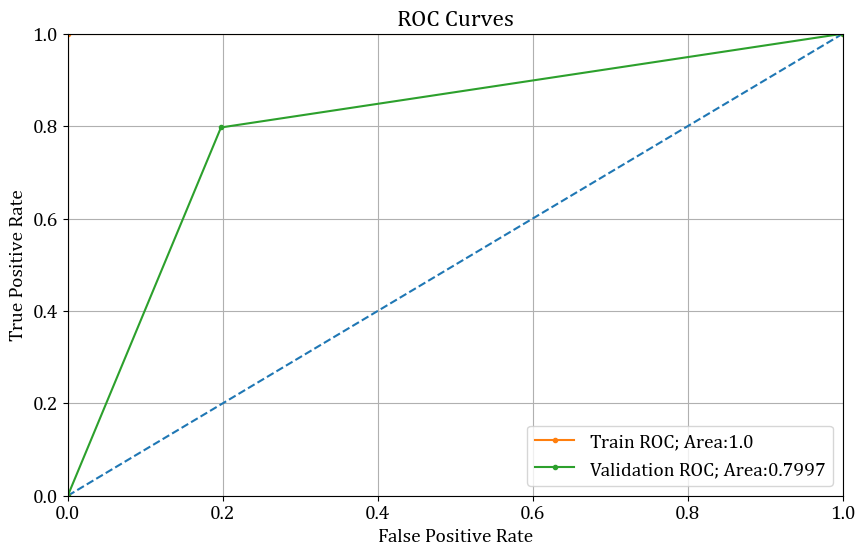

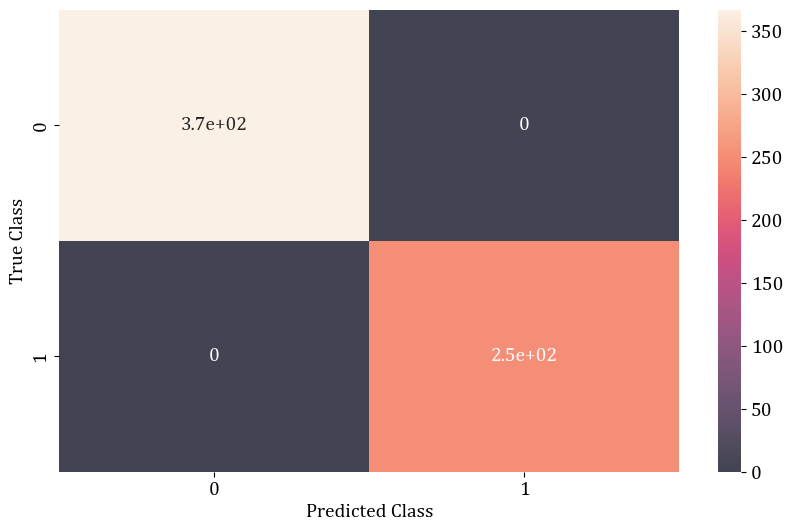

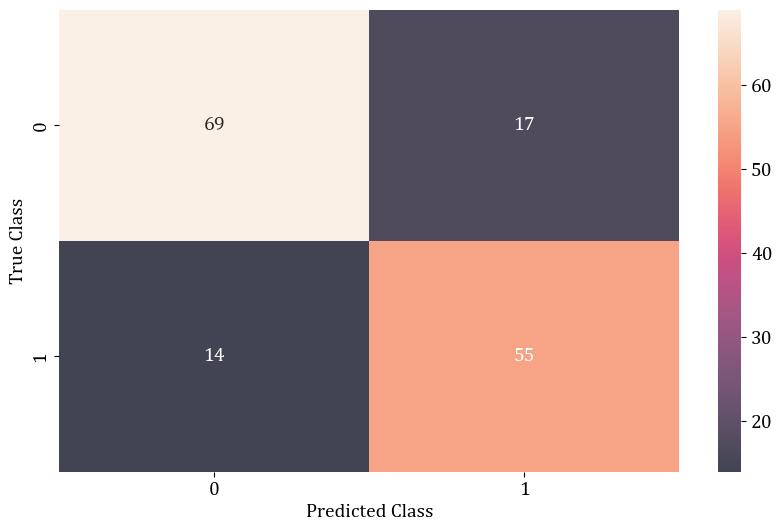

rf_norm_param_tuning


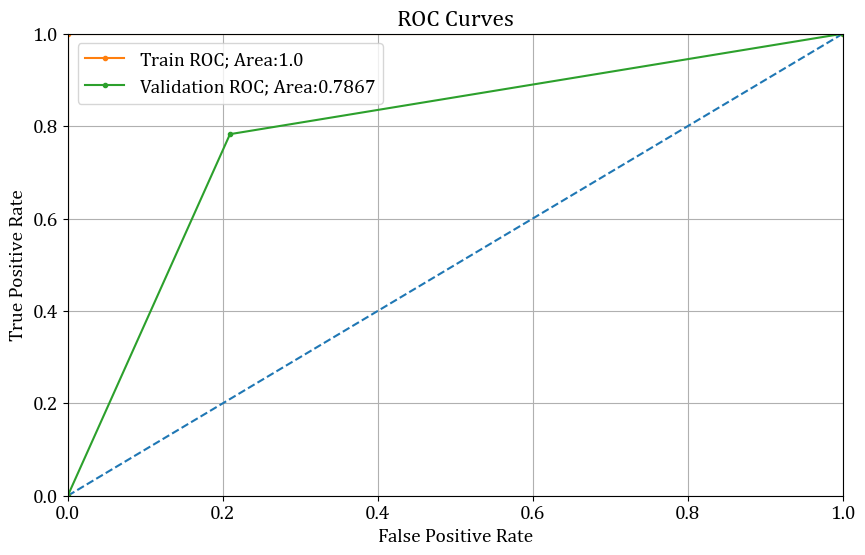

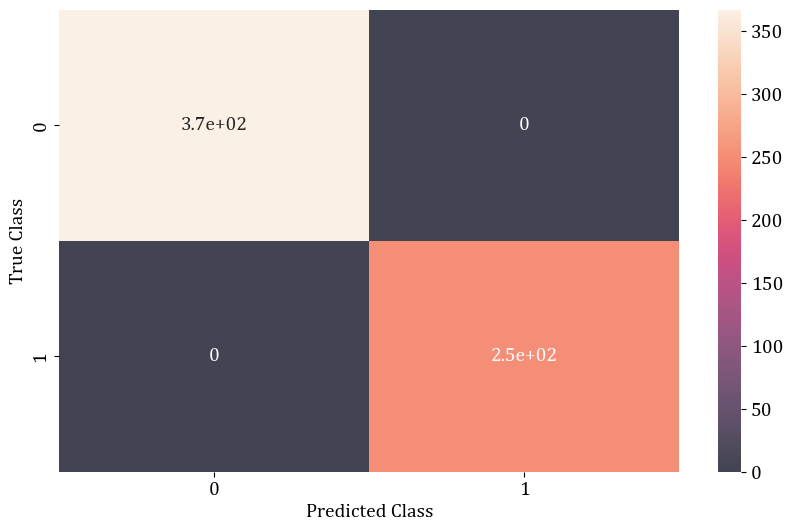

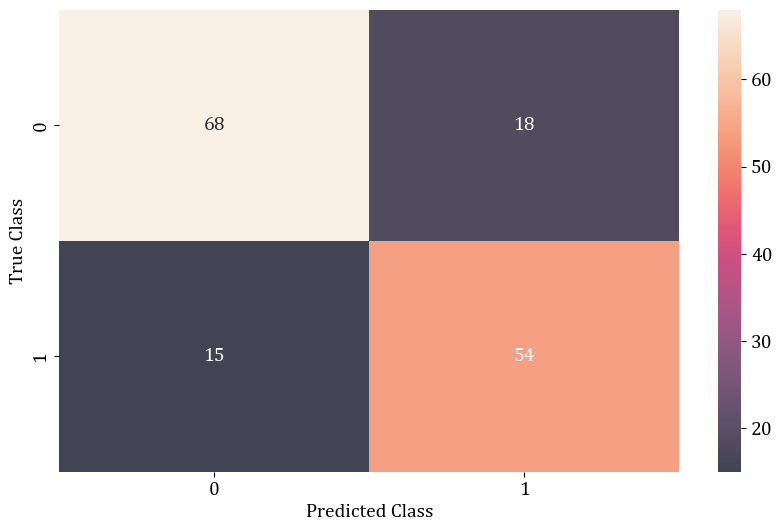

rf_norm_param_tuning


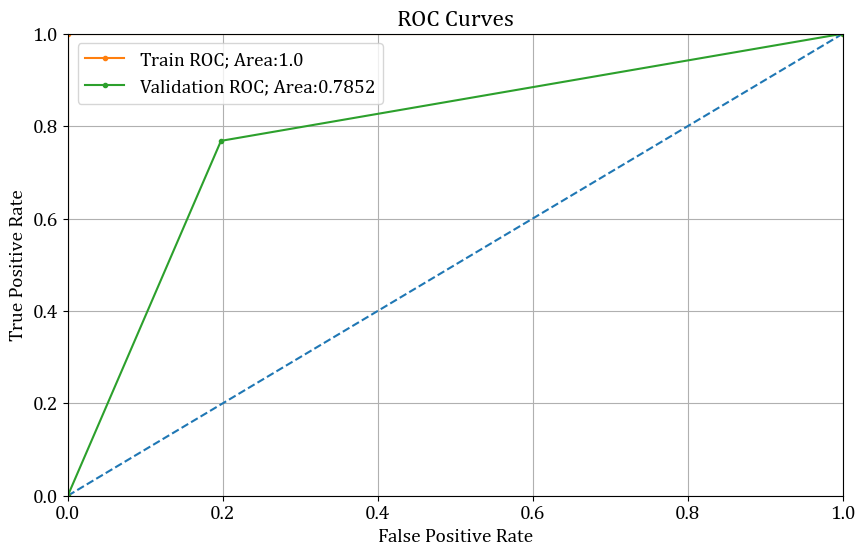

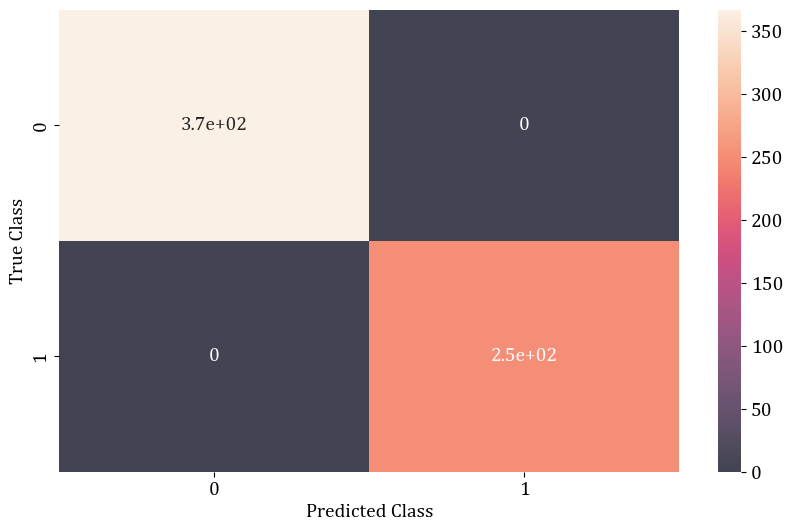

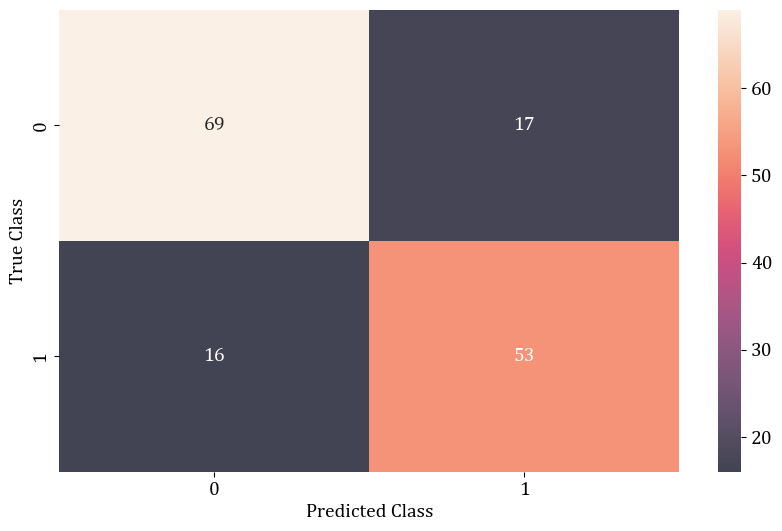

rf_norm_param_tuning


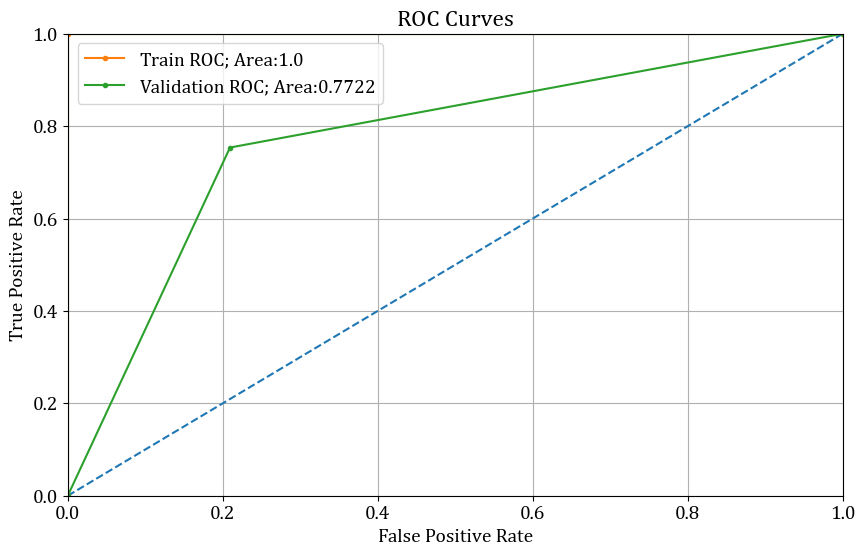

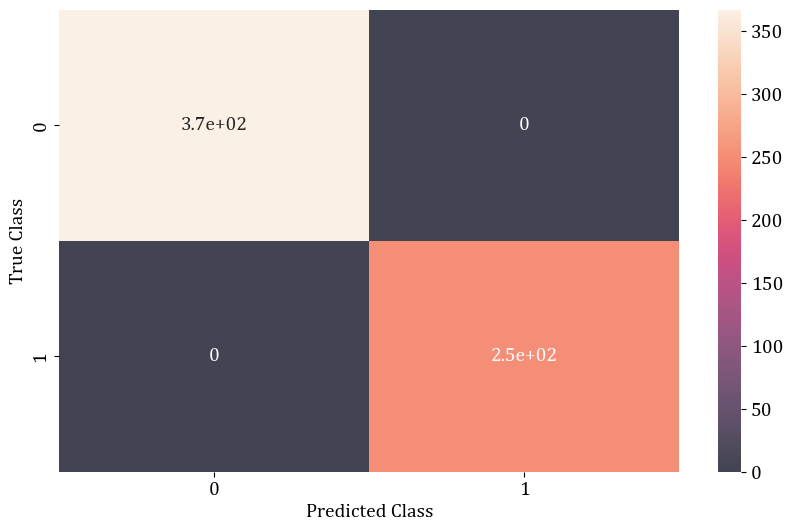

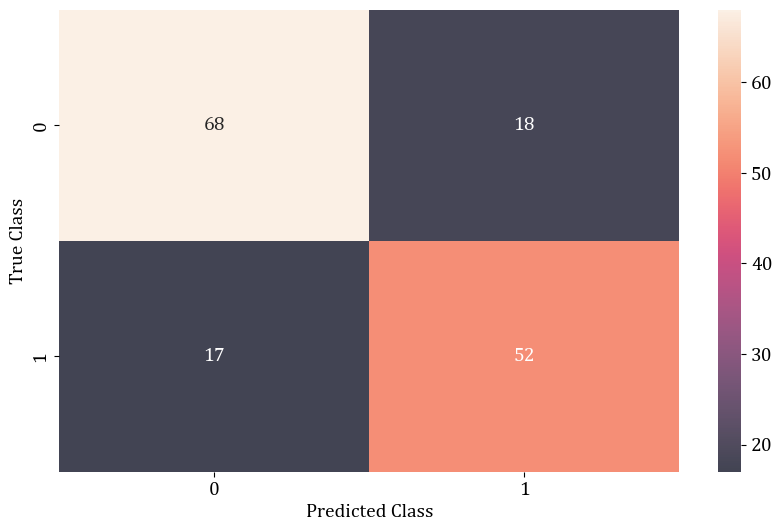

rf_norm_param_tuning


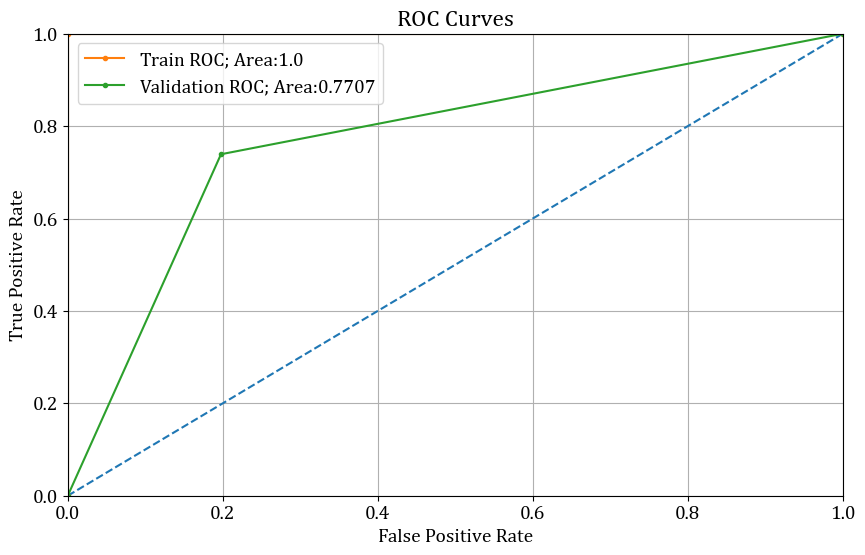

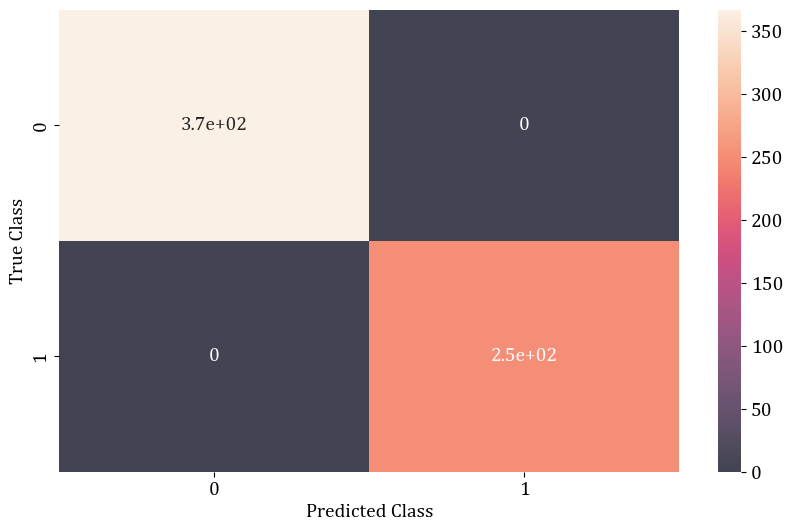

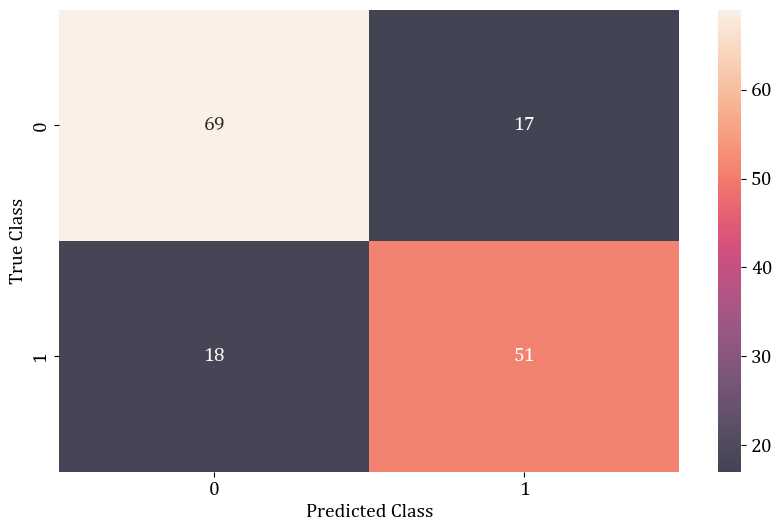

rf_param_tuning


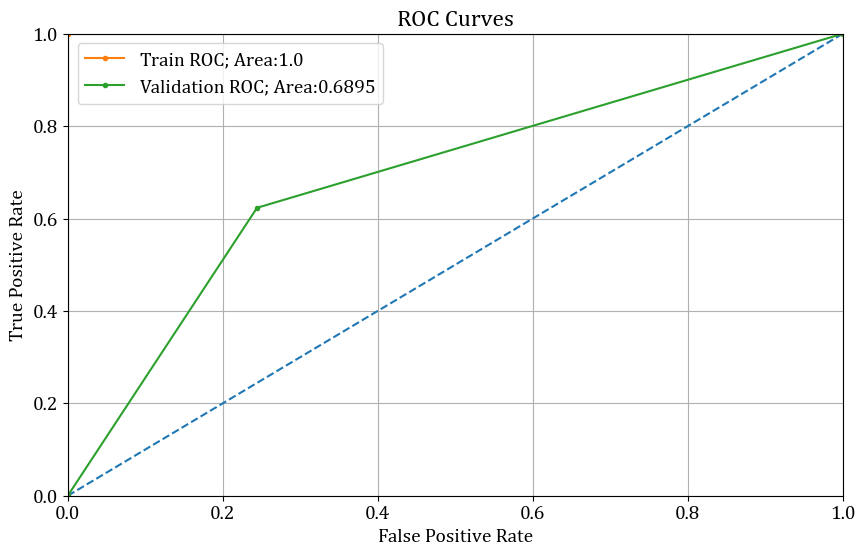

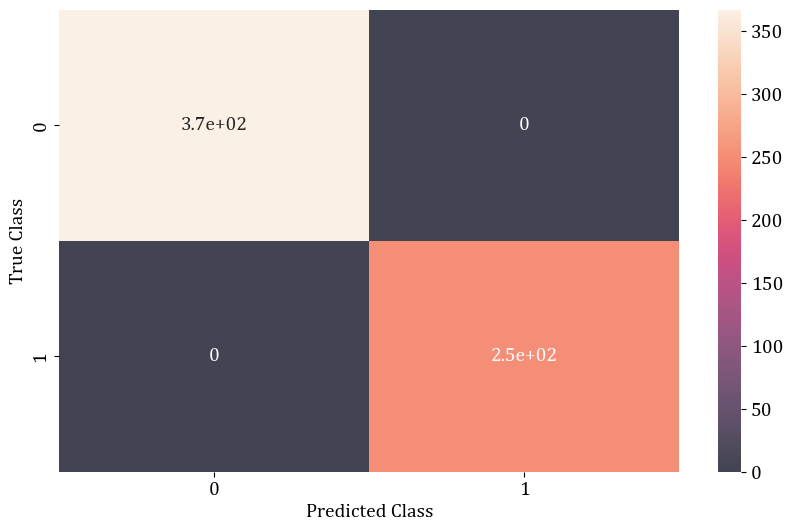

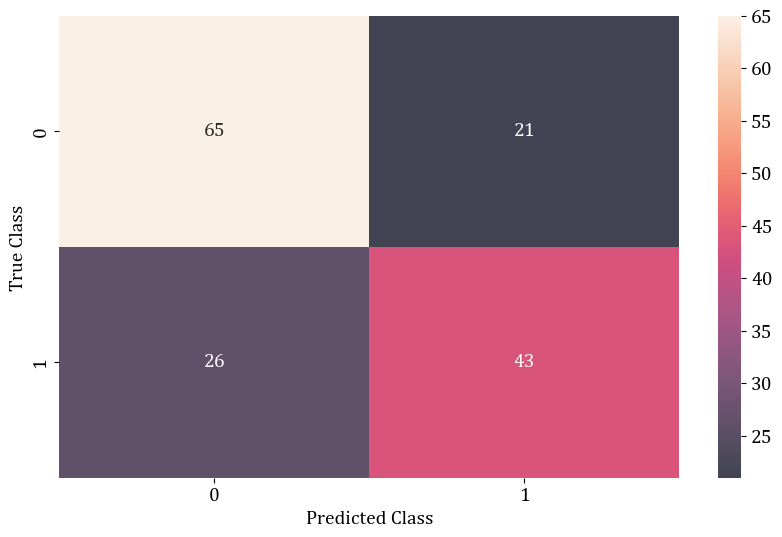

rf_standard_scaler_param_tuning


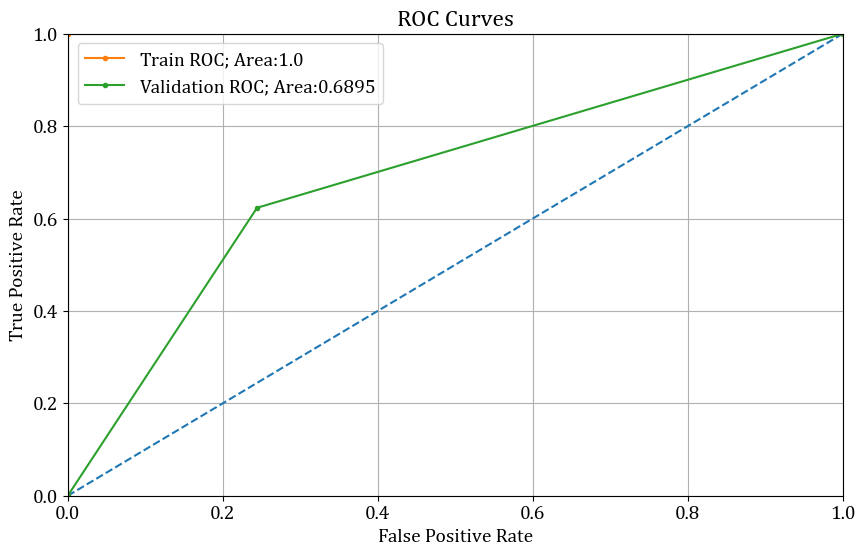

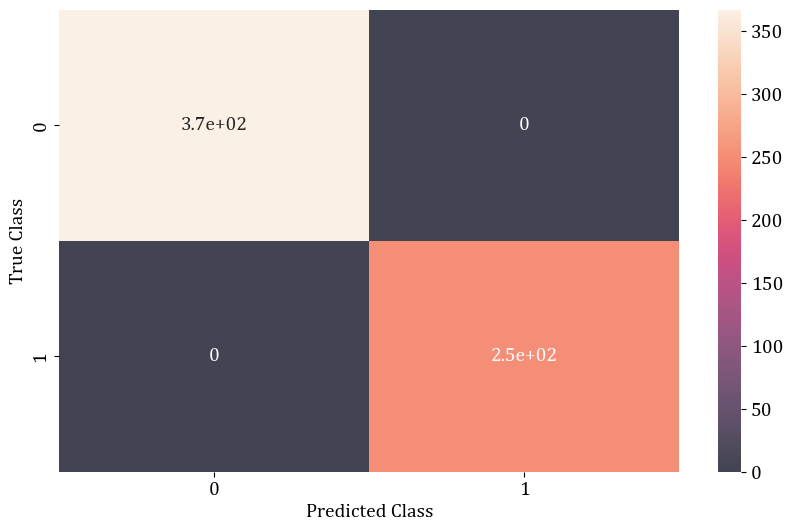

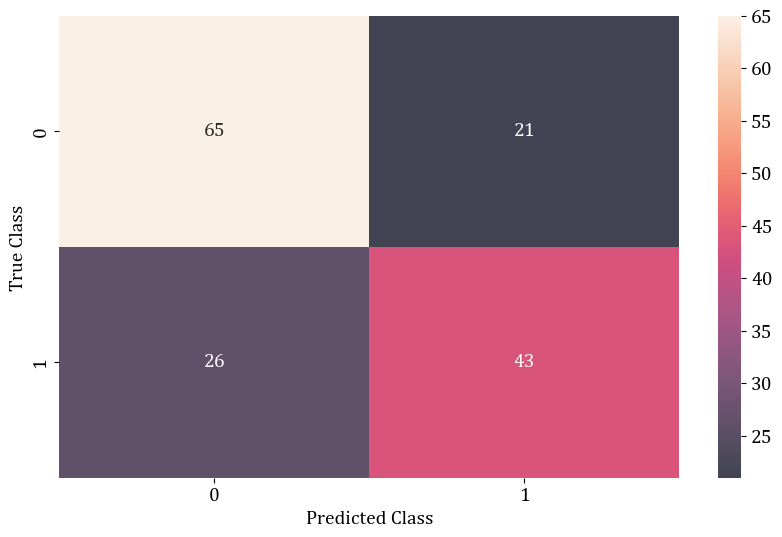

knn_param_tuning


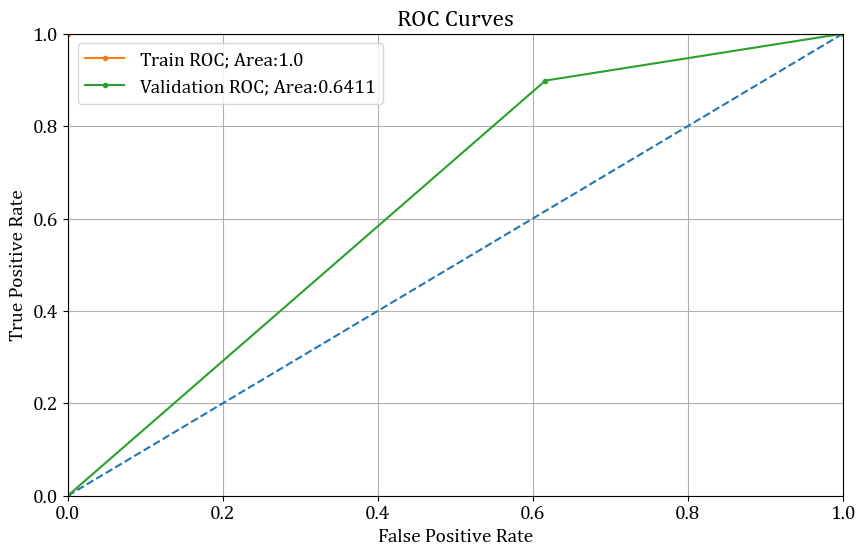

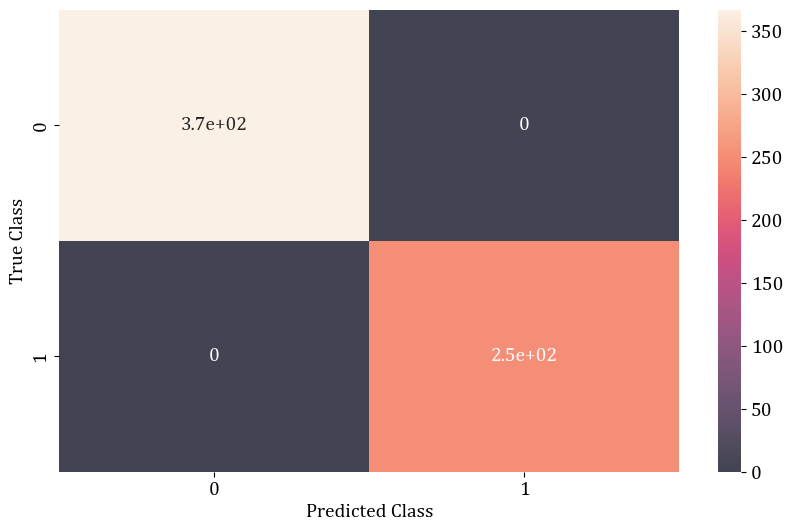

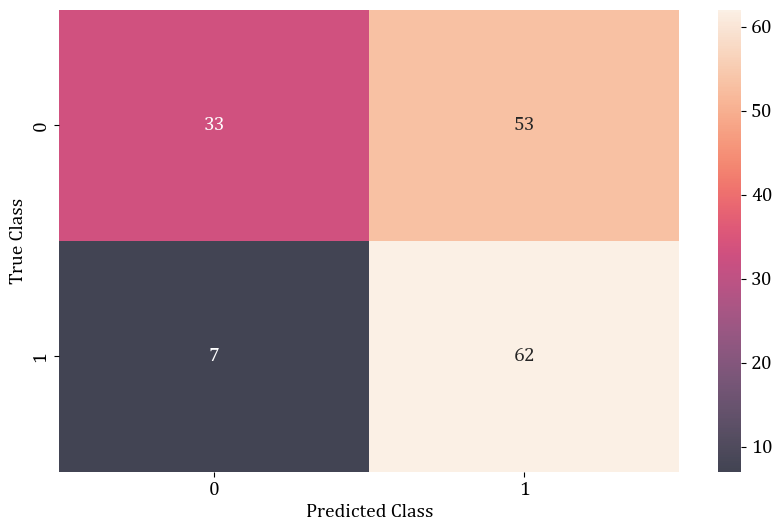

knn_standard_scaler_param_tuning


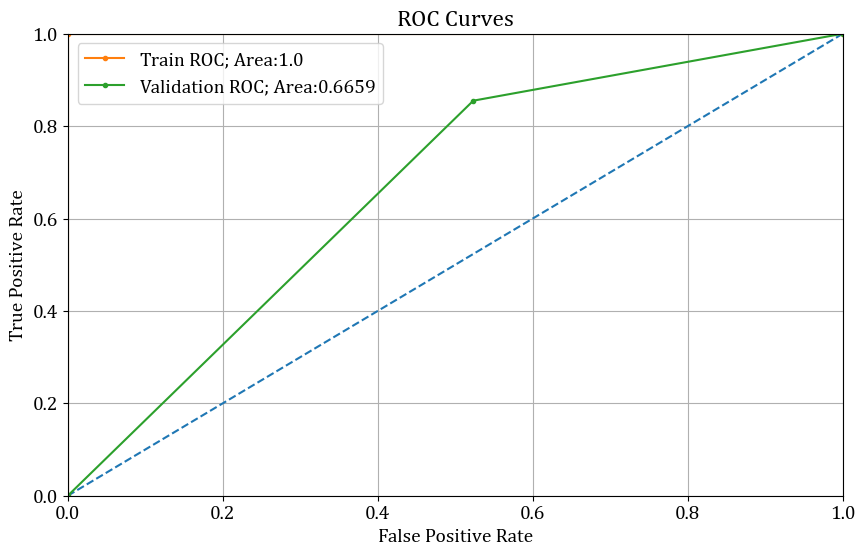

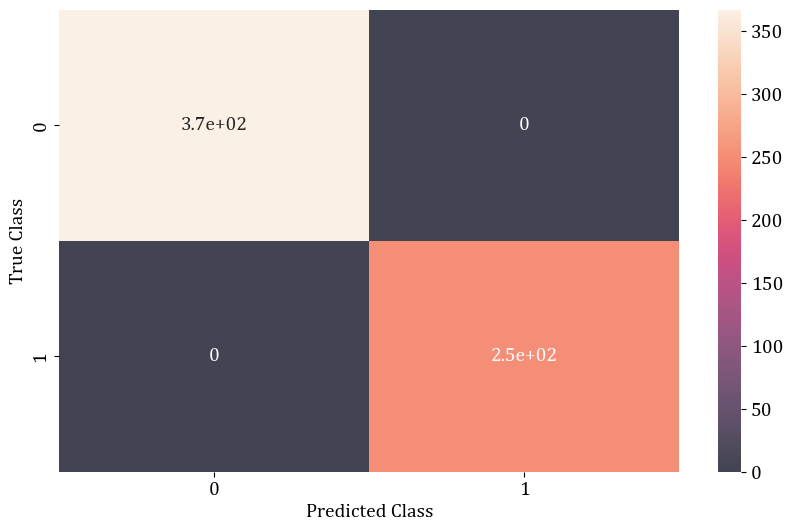

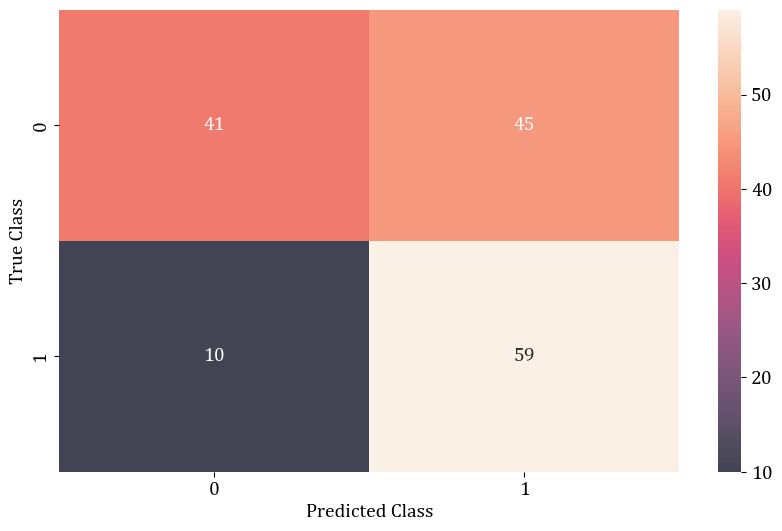

svc_standard_scaler_param_tuning


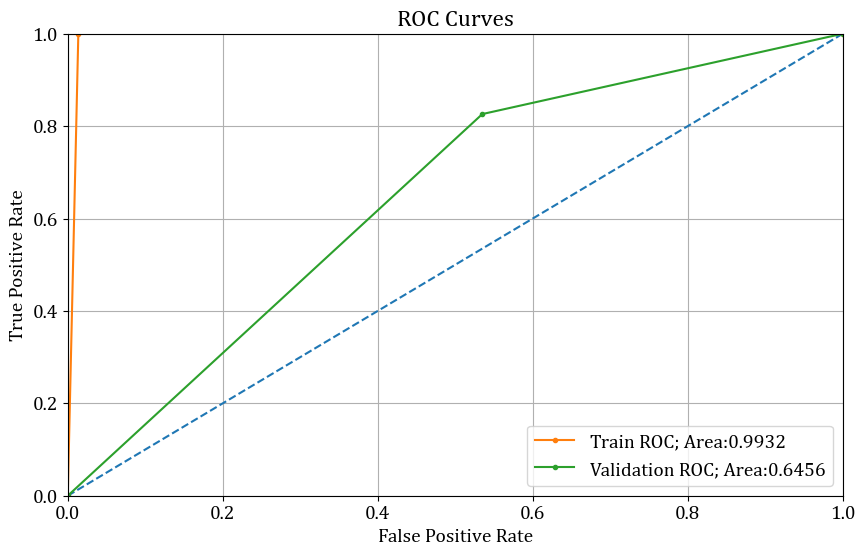

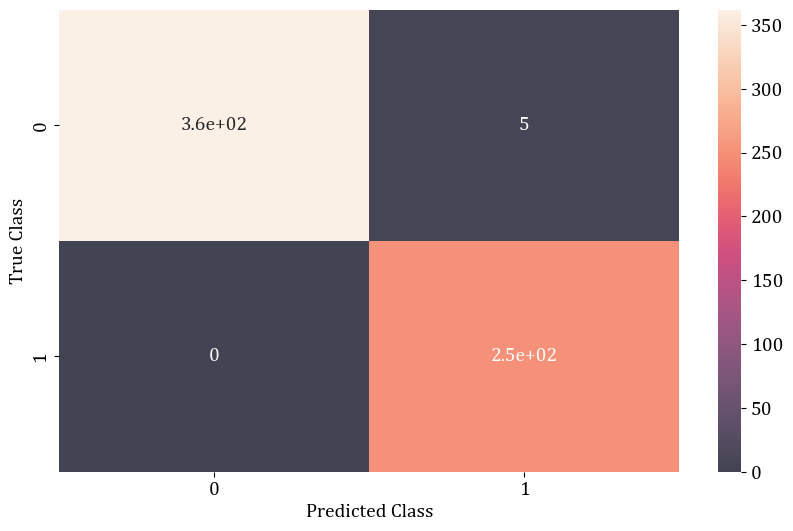

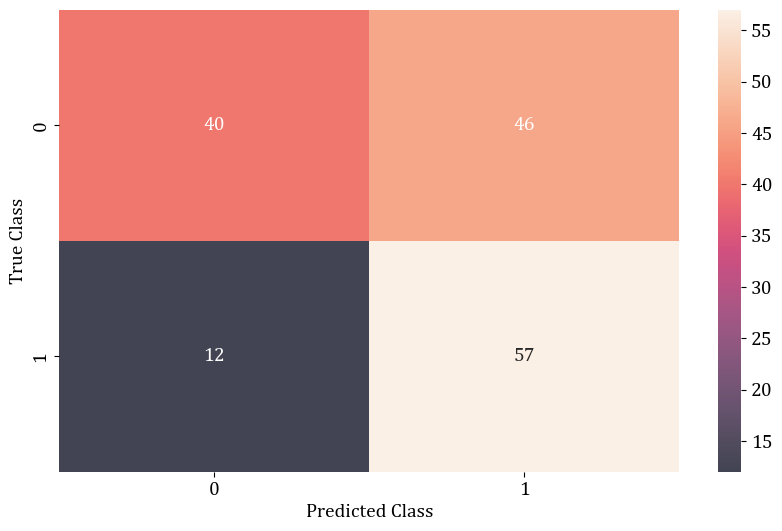

svc_standard_scaler_param_tuning


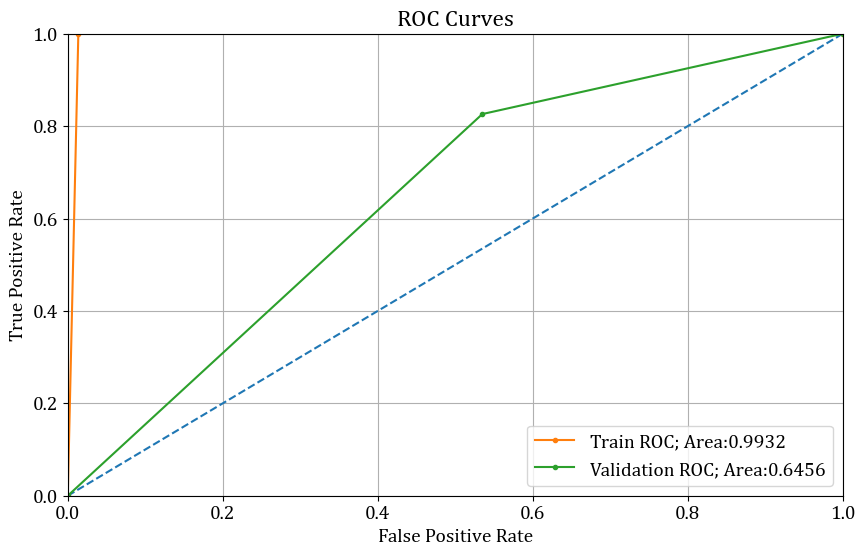

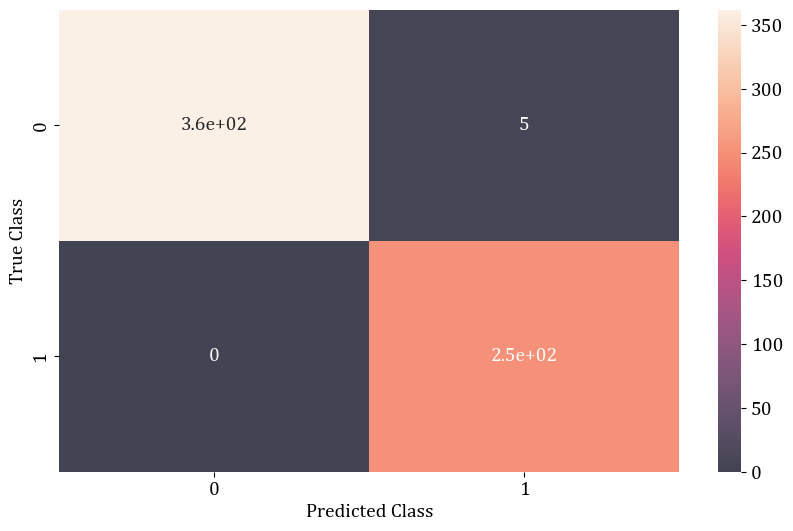

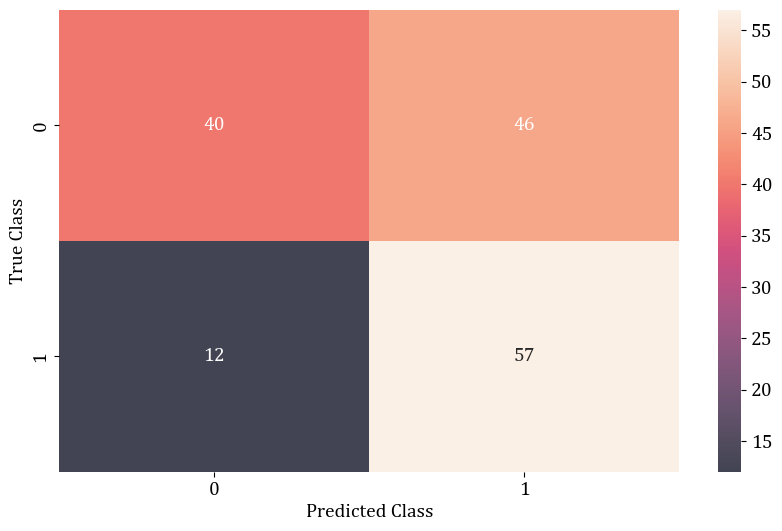

rf_param_tuning


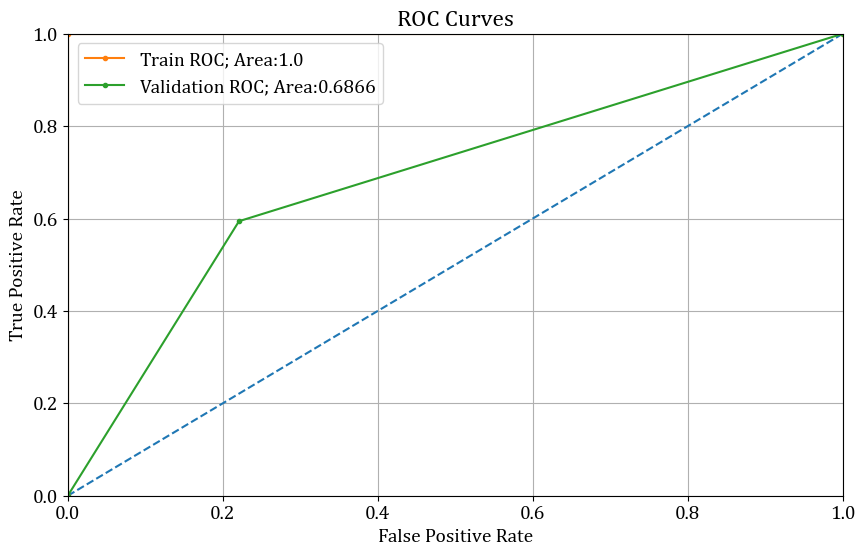

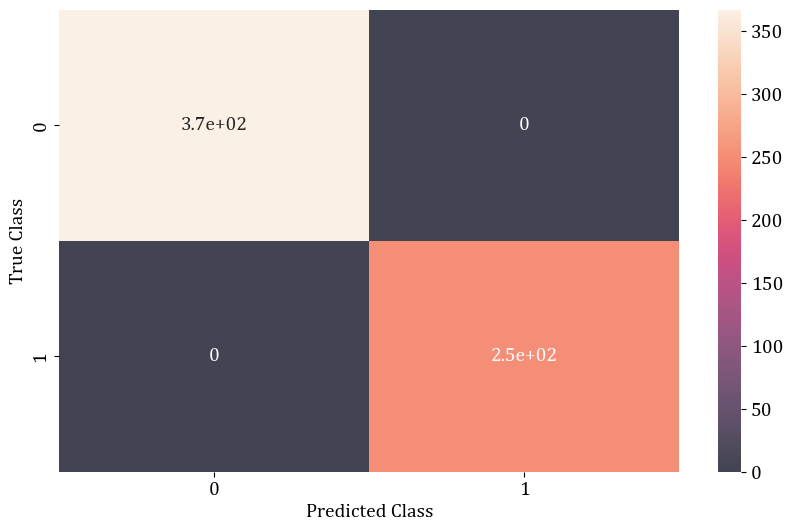

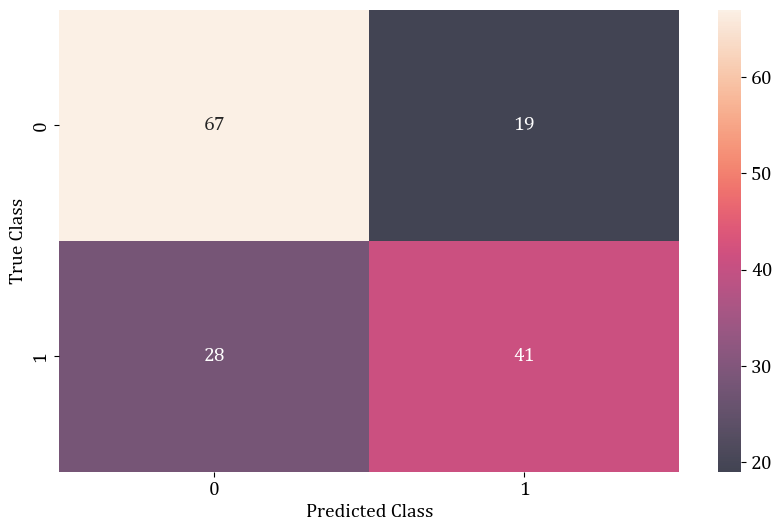

rf_standard_scaler_param_tuning


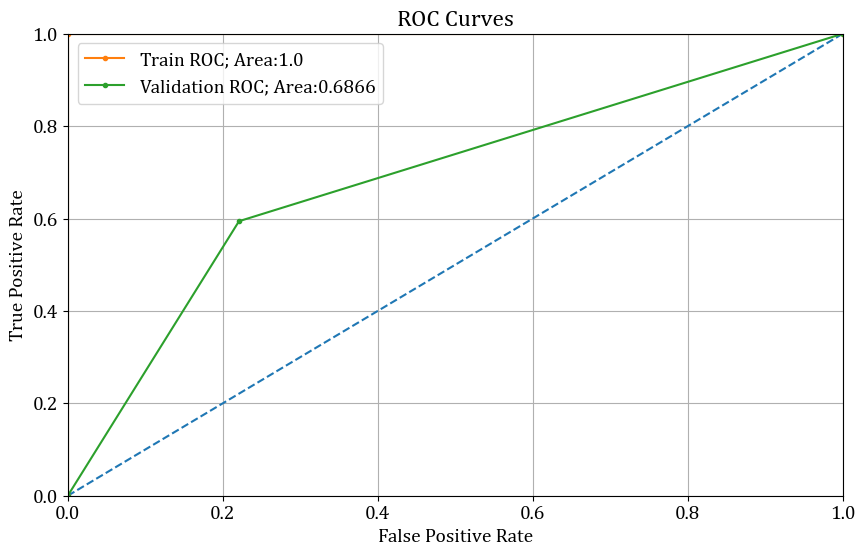

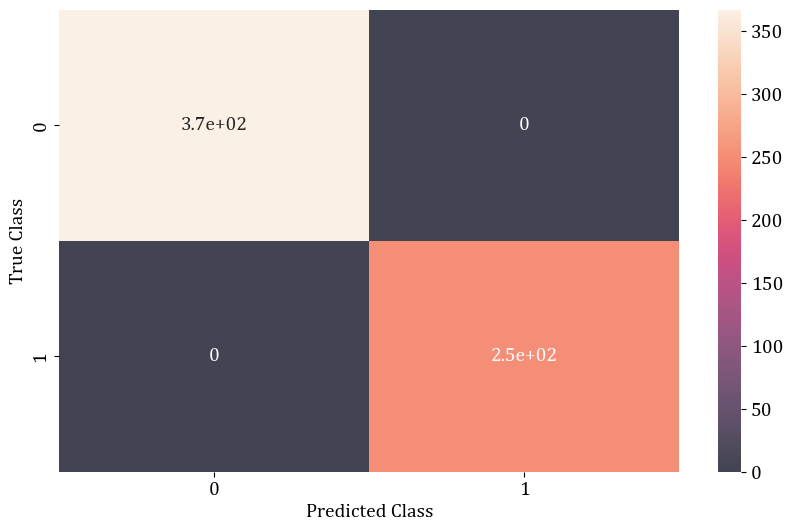

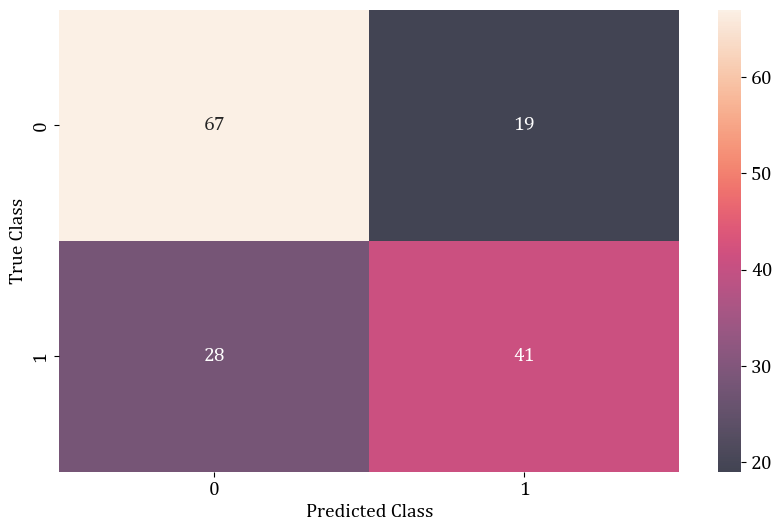

rf_standard_scaler_param_tuning


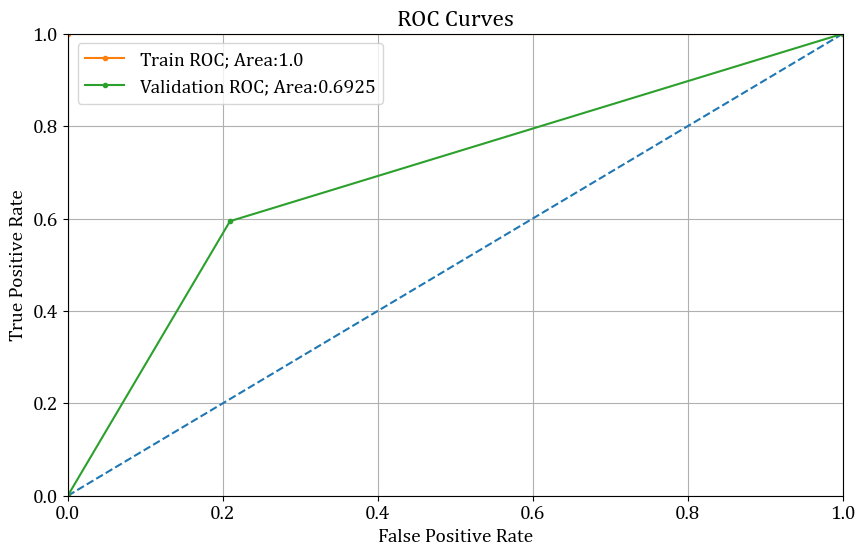

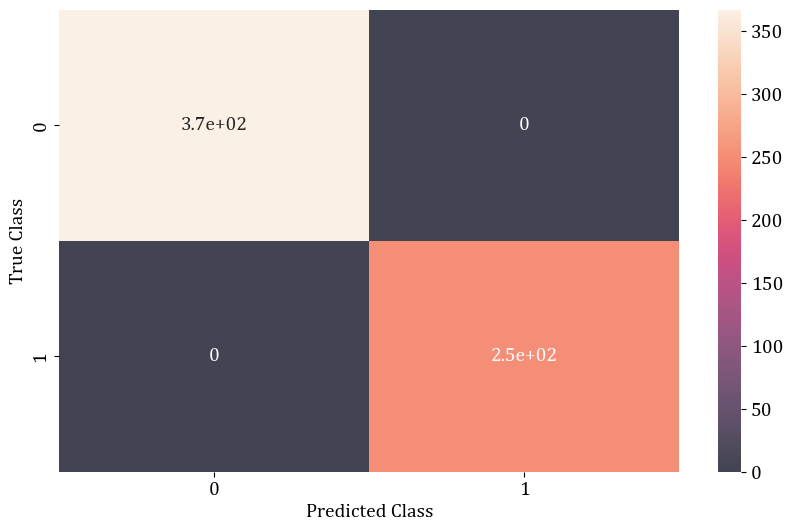

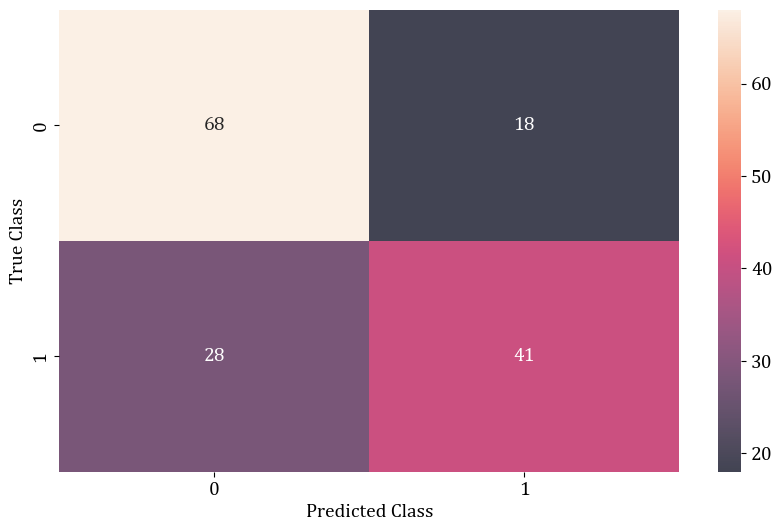

rf_param_tuning


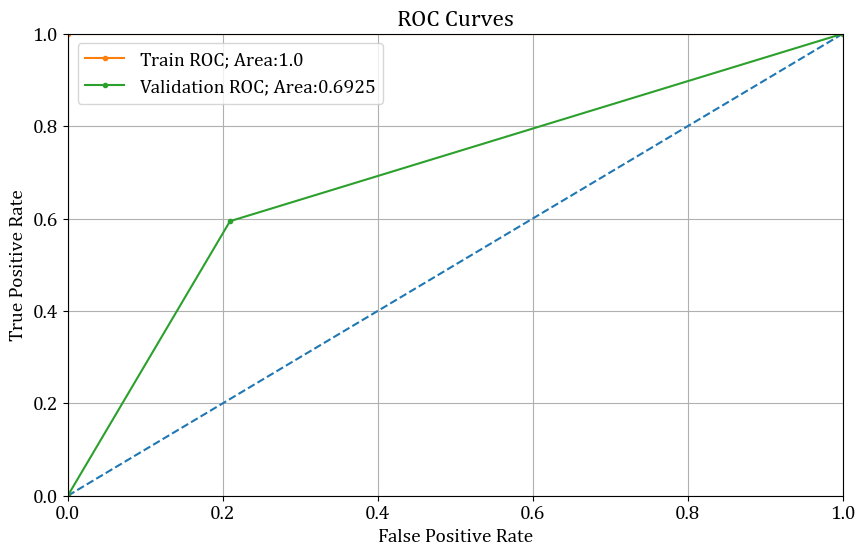

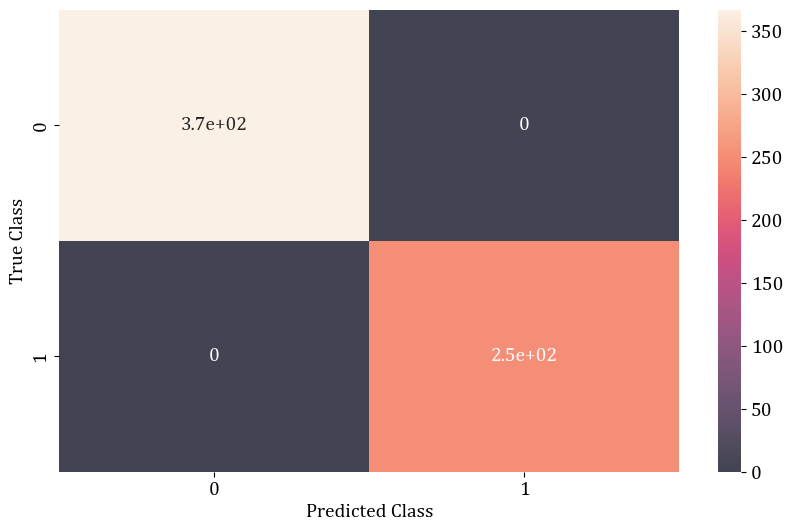

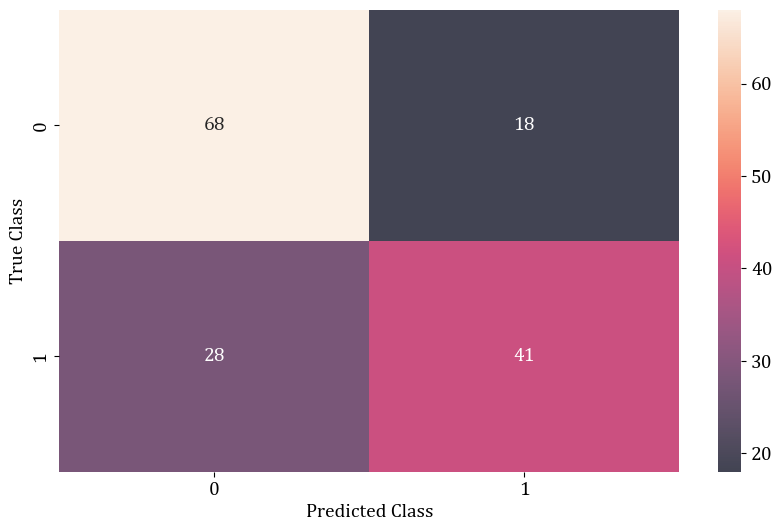

Accuracy: Validation and Test


,name,Name,params,mean_test_score,train_acc,train_f1,val_acc,val_f1,test_acc,test_f1,mean_val_test_acc,mean_val_test_f1
0,rf_norm_param_tuning,RF_ND,"{'max_features': 'sqrt', 'min_samples_split': ...",0.753870,1.000000,1.000000,0.806452,0.777778,1.000000,1.000000,0.903226,0.888889
1,rf_norm_param_tuning,RF_ND,"{'max_features': 'sqrt', 'min_samples_split': ...",0.764653,1.000000,1.000000,0.798387,0.770642,1.000000,1.000000,0.899194,0.885321
2,rf_norm_param_tuning,RF_ND,"{'max_features': 'sqrt', 'min_samples_split': ...",0.775944,1.000000,1.000000,0.798387,0.766355,1.000000,1.000000,0.899194,0.883178
3,rf_norm_param_tuning,RF_ND,"{'max_features': 'sqrt', 'min_samples_split': ...",0.776462,1.000000,1.000000,0.798387,0.766355,1.000000,1.000000,0.899194,0.883178
4,rf_norm_param_tuning,RF_ND,"{'max_features': 'sqrt', 'min_samples_split': ...",0.752134,1.000000,1.000000,0.782258,0.742857,1.000000,1.000000,0.891129,0.871429
5,rf_param_tuning,RF,"{'max_features': 'sqrt', 'min_samples_split': ...",0.619564,1.000000,1.000000,0.733871,0.691589,1.000000,1.000000,0.866935,0.845794
6,rf_standard_scaler_param_tuning,RF_SS,"{'rf__max_features': 'sqrt', 'rf__min_samples_...",0.752134,1.000000,1.000000,0.733871,0.691589,1.000000,1.000000,0.866935,0.845794
13,rf_standard_scaler_param_tuning,RF_SS,"{'rf__max_features': 'sqrt', 'rf__min_samples_...",0.776462,1.000000,1.000000,0.733871,0.666667,1.000000,1.000000,0.866935,0.833333
14,rf_param_tuning,RF,"{'max_features': 'sqrt', 'min_samples_split': ...",0.634982,1.000000,1.000000,0.733871,0.666667,1.000000,1.000000,0.866935,0.833333
11,rf_param_tuning,RF,"{'max_features': 'sqrt', 'min_samples_split': ...",0.630105,1.000000,1.000000,0.725806,0.666667,1.000000,1.000000,0.862903,0.833333


F1 Scores: Validation and Test


,name,Name,params,mean_test_score,train_acc,train_f1,val_acc,val_f1,test_acc,test_f1,mean_val_test_acc,mean_val_test_f1
0,rf_norm_param_tuning,RF_ND,"{'max_features': 'sqrt', 'min_samples_split': ...",0.753870,1.000000,1.000000,0.806452,0.777778,1.000000,1.000000,0.903226,0.888889
1,rf_norm_param_tuning,RF_ND,"{'max_features': 'sqrt', 'min_samples_split': ...",0.764653,1.000000,1.000000,0.798387,0.770642,1.000000,1.000000,0.899194,0.885321
2,rf_norm_param_tuning,RF_ND,"{'max_features': 'sqrt', 'min_samples_split': ...",0.775944,1.000000,1.000000,0.798387,0.766355,1.000000,1.000000,0.899194,0.883178
3,rf_norm_param_tuning,RF_ND,"{'max_features': 'sqrt', 'min_samples_split': ...",0.776462,1.000000,1.000000,0.798387,0.766355,1.000000,1.000000,0.899194,0.883178
4,rf_norm_param_tuning,RF_ND,"{'max_features': 'sqrt', 'min_samples_split': ...",0.752134,1.000000,1.000000,0.782258,0.742857,1.000000,1.000000,0.891129,0.871429
8,knn_standard_scaler_param_tuning,KNN_SS,"{'knn__n_neighbors': 10, 'knn__weights': 'dist...",0.682052,1.000000,1.000000,0.669355,0.700730,1.000000,1.000000,0.834677,0.850365
5,rf_param_tuning,RF,"{'max_features': 'sqrt', 'min_samples_split': ...",0.619564,1.000000,1.000000,0.733871,0.691589,1.000000,1.000000,0.866935,0.845794
6,rf_standard_scaler_param_tuning,RF_SS,"{'rf__max_features': 'sqrt', 'rf__min_samples_...",0.752134,1.000000,1.000000,0.733871,0.691589,1.000000,1.000000,0.866935,0.845794
9,svc_standard_scaler_param_tuning,SVC_SS,"{'svc__C': 10, 'svc__decision_function_shape':...",0.679223,0.991909,0.990138,0.661290,0.686567,0.991909,0.990138,0.826600,0.838353
10,svc_standard_scaler_param_tuning,SVC_SS,"{'svc__C': 10, 'svc__decision_function_shape':...",0.679223,0.991909,0.990138,0.661290,0.686567,0.991909,0.990138,0.826600,0.838353


In [6]:
model_dict = {"MLP": MLPClassifier(random_state=42), "KNN": KNeighborsClassifier(), \
              "LR": LogisticRegression(max_iter=1000, random_state=42), \
              "RF": RandomForestClassifier(random_state=42), "SVC": SVC(random_state=42)}
accuracy_train_list = []
accuracy_val_list = []
accuracy_test_list = []
f1_train_list = []
f1_val_list = []
f1_test_list = []

model_list = []

for model_idx in tqdm(range(num_models)):
    model_name = df["model"][model_idx].upper()
    model_ss = df["SS"][model_idx]
    model_nd = df["norm_data"][model_idx]
    params = eval(df["params"][model_idx])
    new_params = {}
    for i in params:
        if "__" in i:
            new_params[i.split("__")[1]] = params[i]
        else:
            new_params[i] = params[i]
    
    model = model_dict[model_name].set_params(**new_params)
    
    if model_ss:
        model = Pipeline([("scaler", StandardScaler()), (model_name.lower(), model)])
    else:
        model = model
    
    if model_nd:
        model.fit(X_train_norm, y_train)
    else:
        model.fit(X_train, y_train)
    
    model_list.append(model)
    
    if model_nd:
        y_train_pred = model.predict(X_train_norm)
        y_val_pred = model.predict(X_val_norm)
        y_test_pred = model.predict(X_test_norm)
    else:
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        y_test_pred = model.predict(X_test)

    accuracy_train = accuracy_score(y_train, y_train_pred)
    f1_train = f1_score(y_train, y_train_pred)
    accuracy_val = accuracy_score(y_val, y_val_pred)
    f1_val = f1_score(y_val, y_val_pred)
    accuracy_test = accuracy_score(y_train, y_train_pred)
    f1_test = f1_score(y_train, y_train_pred)

    accuracy_train_list.append(accuracy_train)
    accuracy_val_list.append(accuracy_val)
    accuracy_test_list.append(accuracy_test)
    
    f1_train_list.append(f1_train)
    f1_val_list.append(f1_val)
    f1_test_list.append(f1_test)
    
    y_val_test = np.concatenate([y_val, y_test])
    y_val_test_pred = np.concatenate([y_val_pred, y_test_pred])
    
    print(df["name"][model_idx])
    get_roc_curves(y_train, y_train_pred, y_val_test, y_val_test_pred)
    plot_confusion_matrix(y_train, y_train_pred)
    plot_confusion_matrix(y_val_test, y_val_test_pred)
    
################################################################################################    
df["train_acc"] = accuracy_train_list
df["val_acc"] = accuracy_val_list
df["test_acc"] = accuracy_test_list
df["train_f1"] = f1_train_list
df["val_f1"] = f1_val_list
df["test_f1"] = f1_test_list

df["mean_val_test_acc"] = (df["val_acc"]+df["test_acc"])/2
df["mean_val_test_f1"] = (df["val_f1"]+df["test_f1"])/2

print("Accuracy: Validation and Test")
df.sort_values("mean_val_test_acc", ascending=False, inplace=True)
display(df[["name", "Name", "params", "mean_test_score", "train_acc", "train_f1", \
                 "val_acc", "val_f1", "test_acc", "test_f1", "mean_val_test_acc", "mean_val_test_f1"]])

print("F1 Scores: Validation and Test")
df.sort_values("mean_val_test_f1", ascending=False, inplace=True)
display(df[["name", "Name", "params", "mean_test_score", "train_acc", "train_f1", \
                 "val_acc", "val_f1", "test_acc", "test_f1", "mean_val_test_acc", "mean_val_test_f1"]])

In [7]:
df[["name", "Name", "params", "mean_test_score", "train_acc", "train_f1", \
    "val_acc", "val_f1", "test_acc", "test_f1", "mean_val_test_acc", "mean_val_test_f1"]]

,name,Name,params,mean_test_score,train_acc,train_f1,val_acc,val_f1,test_acc,test_f1,mean_val_test_acc,mean_val_test_f1
0,rf_norm_param_tuning,RF_ND,"{'max_features': 'sqrt', 'min_samples_split': ...",0.753870,1.000000,1.000000,0.806452,0.777778,1.000000,1.000000,0.903226,0.888889
1,rf_norm_param_tuning,RF_ND,"{'max_features': 'sqrt', 'min_samples_split': ...",0.764653,1.000000,1.000000,0.798387,0.770642,1.000000,1.000000,0.899194,0.885321
2,rf_norm_param_tuning,RF_ND,"{'max_features': 'sqrt', 'min_samples_split': ...",0.775944,1.000000,1.000000,0.798387,0.766355,1.000000,1.000000,0.899194,0.883178
3,rf_norm_param_tuning,RF_ND,"{'max_features': 'sqrt', 'min_samples_split': ...",0.776462,1.000000,1.000000,0.798387,0.766355,1.000000,1.000000,0.899194,0.883178
4,rf_norm_param_tuning,RF_ND,"{'max_features': 'sqrt', 'min_samples_split': ...",0.752134,1.000000,1.000000,0.782258,0.742857,1.000000,1.000000,0.891129,0.871429
8,knn_standard_scaler_param_tuning,KNN_SS,"{'knn__n_neighbors': 10, 'knn__weights': 'dist...",0.682052,1.000000,1.000000,0.669355,0.700730,1.000000,1.000000,0.834677,0.850365
5,rf_param_tuning,RF,"{'max_features': 'sqrt', 'min_samples_split': ...",0.619564,1.000000,1.000000,0.733871,0.691589,1.000000,1.000000,0.866935,0.845794
6,rf_standard_scaler_param_tuning,RF_SS,"{'rf__max_features': 'sqrt', 'rf__min_samples_...",0.752134,1.000000,1.000000,0.733871,0.691589,1.000000,1.000000,0.866935,0.845794
9,svc_standard_scaler_param_tuning,SVC_SS,"{'svc__C': 10, 'svc__decision_function_shape':...",0.679223,0.991909,0.990138,0.661290,0.686567,0.991909,0.990138,0.826600,0.838353
10,svc_standard_scaler_param_tuning,SVC_SS,"{'svc__C': 10, 'svc__decision_function_shape':...",0.679223,0.991909,0.990138,0.661290,0.686567,0.991909,0.990138,0.826600,0.838353
